# License

**Fuzzy EtEPy** © 2024 by Zsófia Nagy-Perjési, Prof. Dr. Márta Takács  
is licensed under the **Creative Commons Attribution–NonCommercial 4.0 International (CC BY-NC 4.0)**.  
See: [https://creativecommons.org/licenses/by-nc/4.0/](https://creativecommons.org/licenses/by-nc/4.0/)

You may use and adapt this notebook for non-commercial purposes, as long as you give appropriate credit.


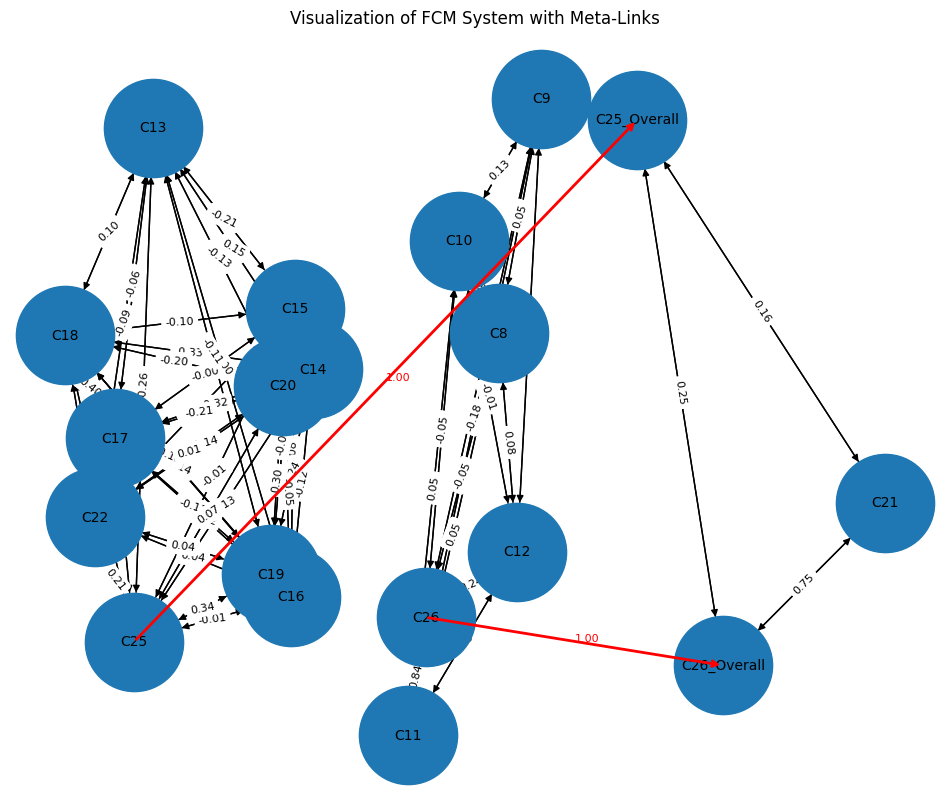

Before update (Behavioral): {'C22': 0.52615439, 'C13': 0.65, 'C14': 0.18, 'C15': 0.35, 'C16': 0.12, 'C17': 0.6, 'C18': 0.1, 'C19': 0.075, 'C20': 0.1, 'C25': 0.0}
After update (Behavioral): {'C22': 0.6230347231793126, 'C13': 0.6251293318629657, 'C14': 0.5116531355278421, 'C15': 0.5241295103419027, 'C16': 0.525410362276258, 'C17': 0.652158283659017, 'C18': 0.5850728921941858, 'C19': 0.49513017872218296, 'C20': 0.49988164019883, 'C25': 0.5818970720618123}
Before update (Environmental): {'C8': 0.0, 'C9': 0.5, 'C10': 0.0, 'C11': 1.0, 'C12': 1.0, 'C26': 0.0}
After update (Environmental): {'C8': 0.5387876926041055, 'C9': 0.588100460056193, 'C10': 0.5176353117273542, 'C11': 0.7213632391402061, 'C12': 0.749030471341062, 'C26': 0.7169575768023096}
Dispatching 0.5818970720618123 from C25 (Behavioral) to C25_Overall (Overall Risk) with weight 1.
Dispatching 0.7169575768023096 from C26 (Environmental) to C26_Overall (Overall Risk) with weight 1.
Before update (Overall Risk): {'C21': 0.0, 'C25_Overa

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class FCM:
    def __init__(self, name):
        self.name = name
        self.graph = nx.DiGraph()
        self.values = {}

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))  # Sigmoid activation function

    def load_from_weight_matrix(self, file_path):
        matrix = pd.read_csv(file_path, index_col=0)
        matrix.index = matrix.index.str.strip()
        matrix.columns = matrix.columns.str.strip()
        nodes = matrix.index.tolist()
        
        # Add nodes and edges
        for node in nodes:
            self.graph.add_node(node)
        for source in nodes:
            for target in nodes:
                weight = matrix.at[source, target]
                if weight != 0:
                    self.graph.add_edge(source, target, weight=weight)
        
        # Initialize concept values to 0
        self.values = {node: 0.0 for node in nodes}

    def load_initial_values(self, file_path):
        initial_values = pd.read_csv(file_path)
        for _, row in initial_values.iterrows():
            concept = row['Concept'].strip()
            value = row['InitialValue']
            if concept in self.values:
                self.values[concept] = value

    def update_values(self):
        # Update values based on the weight matrix
        new_values = self.values.copy()
        for node in self.graph.nodes:
            incoming_edges = self.graph.in_edges(node, data=True)
            new_value = sum(self.values[source] * data['weight'] for source, _, data in incoming_edges)
            new_values[node] = self.sigmoid(new_value)  # Apply sigmoid activation function
        self.values = new_values

class MetaFCMSystem:
    def __init__(self):
        self.fcms = {}
        self.meta_links = []

    def add_fcm(self, fcm):
        self.fcms[fcm.name] = fcm

    def load_meta_links_from_csv(self, file_path):
        data = pd.read_csv(file_path)
        for _, row in data.iterrows():
            self.meta_links.append({
                "source_fcm": row['Source_FCM'],
                "source_node": row['Source_Node'],
                "target_fcm": row['Target_FCM'],
                "target_node": row['Target_Node'],
                "weight": row['Weight']
            })

    def visualize(self):
        fig, ax = plt.subplots(figsize=(12, 10))
        pos = {}
        offset = 0

        for fcm_name, fcm in self.fcms.items():
            sub_pos = nx.spring_layout(fcm.graph, center=(offset, 0))
            nx.draw(fcm.graph, pos=sub_pos, with_labels=True, ax=ax, node_size=5000, font_size=10)
            nx.draw_networkx_edge_labels(
                fcm.graph, pos=sub_pos,
                edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in fcm.graph.edges(data=True)},
                font_size=8, ax=ax
            )
            pos.update(sub_pos)
            offset += 2  # Shift each FCM to its own cluster

        for link in self.meta_links:
            source_node = link['source_node']
            target_node = link['target_node']
            source_fcm = self.fcms[link['source_fcm']]
            target_fcm = self.fcms[link['target_fcm']]
            if source_node in source_fcm.values and target_node in target_fcm.values:
                source_pos = pos[source_node]
                target_pos = pos[target_node]
                ax.annotate("", xy=target_pos, xytext=source_pos,
                            arrowprops=dict(arrowstyle="->", color="red", lw=2))
                ax.text((source_pos[0] + target_pos[0]) / 2,
                        (source_pos[1] + target_pos[1]) / 2,
                        f"{link['weight']:.2f}", color="red", fontsize=8)

        plt.title("Visualization of FCM System with Meta-Links")
        plt.show()

    def simulate(self):
        # Step 1: Update Behavioral and Environmental FCMs
        for fcm_name in ['Behavioral', 'Environmental']:
            fcm = self.fcms[fcm_name]
            print(f"Before update ({fcm_name}):", fcm.values)  # Debug: Initial values
            fcm.update_values()
            print(f"After update ({fcm_name}):", fcm.values)  # Debug: Updated values

        # Step 2: Dispatch values via meta-links (directly update Overall Risk FCM)
        overall_risk_fcm = self.fcms['Overall Risk']
        for link in self.meta_links:
            source_fcm = self.fcms[link['source_fcm']]
            target_node = link['target_node']
            source_value = source_fcm.values[link['source_node']]

            # Ensure target node exists in Overall Risk FCM
            if target_node in overall_risk_fcm.values:
                print(f"Dispatching {source_value} from {link['source_node']} ({link['source_fcm']}) "
                      f"to {target_node} (Overall Risk) with weight {link['weight']}.")  # Debug
                overall_risk_fcm.values[target_node] = source_value * link['weight']
            else:
                print(f"Warning: Target node {target_node} not found in Overall Risk FCM.")  # Debug

        # Step 3: Update Overall Risk FCM
        print(f"Before update (Overall Risk):", overall_risk_fcm.values)  # Debug: Initial values
        overall_risk_fcm.update_values()
        print(f"After update (Overall Risk):", overall_risk_fcm.values)  # Debug: Updated values

        # Output key results
        return {
            "C25 (Behavioral Risk)": self.fcms['Behavioral'].values['C25'],
            "C26 (Environmental Risk)": self.fcms['Environmental'].values['C26'],
            "C25 (Overall Risk)": self.fcms['Overall Risk'].values['C25_Overall'],
            "C26 (Overall Risk)": self.fcms['Overall Risk'].values['C26_Overall'],
            "C21 (Overall Risk)": self.fcms['Overall Risk'].values['C21']
        }

# Example Usage
system = MetaFCMSystem()

# Load FCMs from weight matrices
behavioral_fcm = FCM("Behavioral")
behavioral_fcm.load_from_weight_matrix("NHL_Behavioral_w_summarized_Nutrition_trained_weight_matrix_Data_based_061202024.csv")
behavioral_fcm.load_initial_values("Normalized_Dataset_Test_Behavioral_w_Nutrition_summary_Av_Beh_B_Ex.csv")
system.add_fcm(behavioral_fcm)

environmental_fcm = FCM("Environmental")
environmental_fcm.load_from_weight_matrix("NHL_Environmental_trained_weight_matrix_Data_based_061202024.csv")
environmental_fcm.load_initial_values("Normalized_Dataset_Test_Environmental_Av_Beh_B_Ex.csv")
system.add_fcm(environmental_fcm)

overall_risk_fcm = FCM("Overall Risk")
overall_risk_fcm.load_from_weight_matrix("NHL_Overall_trained_weight_matrix_Data_based_061202024_mod.csv")
system.add_fcm(overall_risk_fcm)

# Load meta-links from CSV
system.load_meta_links_from_csv("metalinks.csv")

# Visualize the system
system.visualize()

# Simulate
result = system.simulate()
print("Simulation Results:", result)